In [26]:
from pax import core, utils, datastructure
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
import numpy as np

In [2]:
# Make sure same PMTs are dead as Neural Net expects
# Well, "PMT 0" is also dead :-)
gains = np.ones(243) * 2e6
dead_pmts = np.array([0, 9, 12, 39, 58])
gains[dead_pmts] = 0

In [89]:
# Load the posrec plugins
plugins_to_test = [
    ('NeuralNet', 'PosRecNeuralNet'),
    ('PosSimple', 'PosRecWeightedSum'),
    ('PosRecChiSquareGamma', 'PosRecChiSquareGamma'),
]
mypax = core.Processor(config_names=['XENON100', 'posrecChi'], config_dict={
    'pax': {
            'plugin_group_names': ['test'],
            'test':               ["%s.%s" % (a, b) for a, b in plugins_to_test],},
    'DEFAULT': {
            'gains': gains,}
})
posrec_plugin = {b: mypax.get_plugin_by_name(b) for a,b in plugins_to_test}

In [90]:
itpm = utils.InterpolatingMap(utils.data_file_name('s2_xy_lce_map_XENON100_Xerawdp0.4.5.json.gz'))

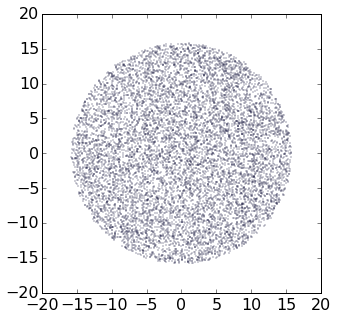

In [91]:
# Check that sampling algorithm is correct

def uniform_circle_rv(radius, n_samples):
    xs = []
    ys = []
    for sample_i in range(n_samples):
        while True:
            x = np.random.uniform(-16, 16)
            y = np.random.uniform(-16, 16)
            if x**2 + y**2 <= radius**2:
                break
        xs.append(x)
        ys.append(y)
    return xs, ys

detector_radius = 15.8

xs, ys = uniform_circle_rv(detector_radius, 10000)
plt.figure(figsize=(5,5))
plt.scatter(xs, ys, s=1, edgecolor=None, alpha=0.2)
plt.show()

In [92]:
def euclideandifference(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

In [93]:
n_pe = 690
#n_pe = 100000
n_trials = 2000
n_peaks = 1   
rps = {}
differences = {}

xs, ys = uniform_circle_rv(detector_radius, n_trials)

# TODO: if n_peaks != 1, tile xs, ys

for sample_i in tqdm(range(n_trials)):
    x = xs[sample_i]
    y = ys[sample_i]

    # Calculate cumulative sum of relative LCEs at this position
    # The fake PMT 0 always gets LCE 0 to ensure no photon enters into it
    lces = [0] + [itpm.get_value(x, y, map_name=str(ch)) for ch in range(1, 98+1)]
    lces = np.array(lces)
    lces_cum = np.cumsum(lces)

    # Generate n_pe * n_peaks_per_position photons
    channel_for_p = np.searchsorted(lces_cum, np.random.uniform(0, 1, n_pe * n_peaks))
    
    # Delete photons in dead pmts
    channel_for_p = channel_for_p[True ^ np.in1d(channel_for_p, dead_pmts)]

    # Split photons into individual peaks, add them into a single event 
    e = datastructure.Event.empty_event()
    for hitpattern_top in channel_for_p.reshape(n_peaks, -1):
        hitp = np.concatenate((np.bincount(hitpattern_top, minlength=98 + 1), np.zeros(242-98)))
        
        # Clip hitpattern at 5k pe / channel to simulate saturation
        # TODO: where should we clip? 5k is just a random guesss
        hitp = np.clip(hitp, 0, 5 * 10**3)
        
        e.peaks.append(datastructure.Peak({
            'left':  5,
            'right': 9,
            'type':  'S2',
            'detector':  'tpc',
            'area_per_channel': hitp}))

    # Run posrec plugins, collect results
    for pp_name, pp in posrec_plugin.items():
        differences[pp_name] = differences.get(pp_name, [])
        rps[pp_name] = rps.get(pp_name, [])
        e = pp.transform_event(e)
        for peak in e.peaks:
            rp = peak.reconstructed_positions[-1]
            rps[pp_name].append((rp.x, rp.y))
            differences[pp_name].append(
                euclideandifference(rp.x, rp.y, x, y))

# Convert position list of tuples to numpy array
for pp_name, pp in posrec_plugin.items():            
    rps[pp_name] = np.array(rps[pp_name])

|----------| 8/2000   0% [elapsed: 00:03 left: 15:06,  2.20 iters/sec]

C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1758: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2300: RuntimeWarning: invalid value encountered in subtract
  if (fx2 - fval) > delta:


|----------| 72/2000   3% [elapsed: 00:35 left: 15:40,  2.05 iters/sec]

C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2309: RuntimeWarning: invalid value encountered in subtract
  if 2.0 * (fx - fval) <= bnd:
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2063: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


|#########-| 1988/2000  99% [elapsed: 15:24 left: 00:05,  2.15 iters/sec]

C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2323: RuntimeWarning: invalid value encountered in double_scalars
  t = 2.0*(fx + fx2 - 2.0*fval)
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2324: RuntimeWarning: invalid value encountered in subtract
  temp = (fx - fval - delta)
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2327: RuntimeWarning: invalid value encountered in double_scalars
  t -= delta*temp*temp
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1759: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


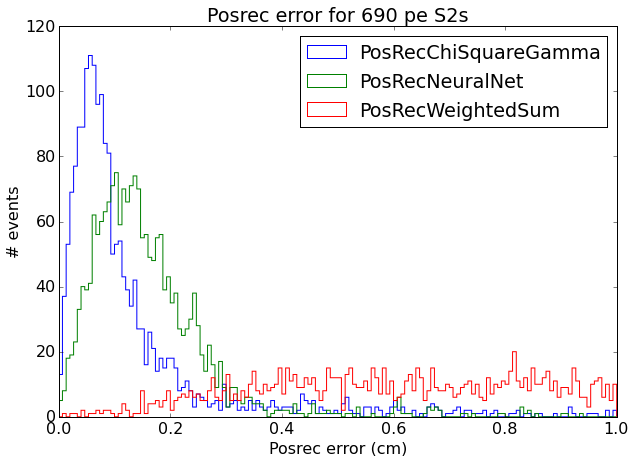

In [95]:
plt.figure(figsize=(10, 7))
for pp_name, pp in posrec_plugin.items():
    plt.hist(differences[pp_name], bins=150, range=(0, 1), histtype='step', label=pp_name)
plt.title('Posrec error for %d pe S2s' % n_pe)
plt.legend(loc='upper right')
plt.xlabel('Posrec error (cm)')
plt.ylabel('# events')
#plt.savefig('nice.png')
plt.show()

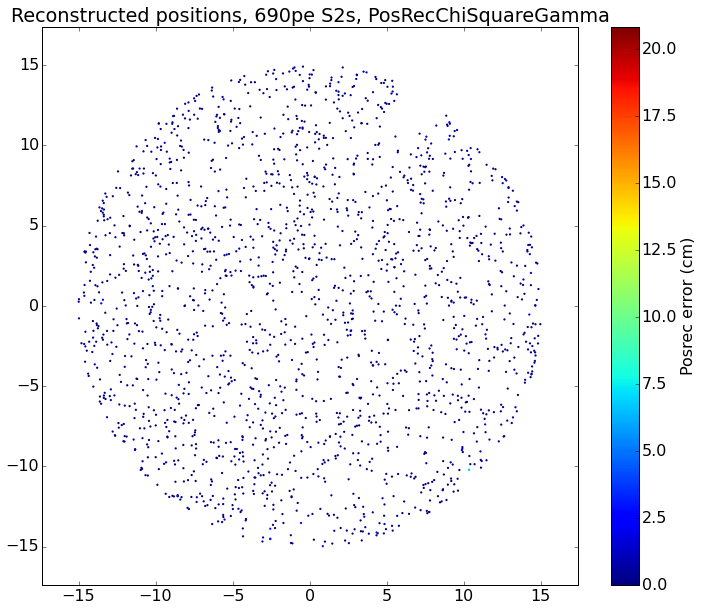

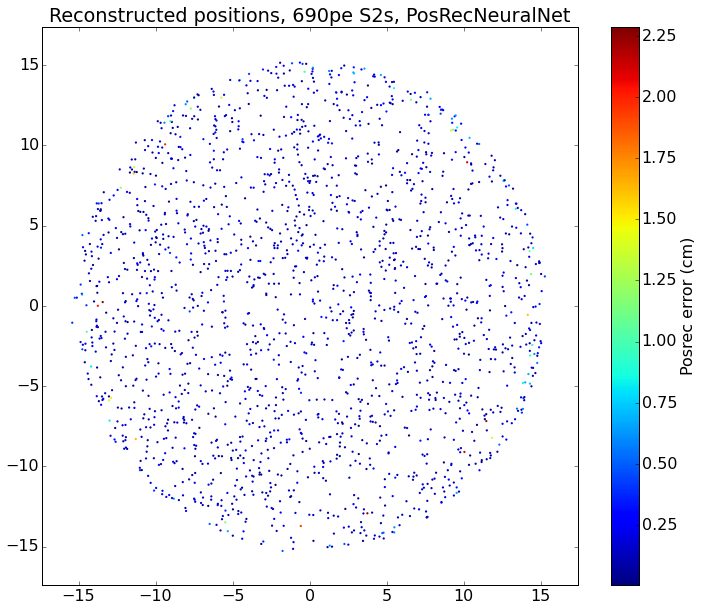

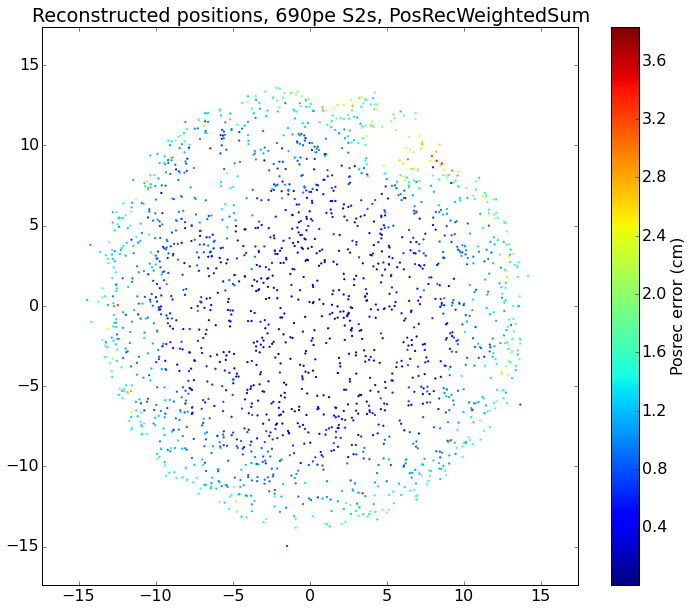

In [96]:
for pp_name in  posrec_plugin.keys():
    plt.figure(figsize=(12,10))
    plt.scatter(rps[pp_name][:,0], rps[pp_name][:,1],
                c=differences[pp_name], marker='.', edgecolors='none')
    plt.colorbar(label='Posrec error (cm)')
    plt.title('Reconstructed positions, %dpe S2s, %s' % (n_pe, pp_name))
    plt.xlim(-1.1*detector_radius, 1.1*detector_radius)
    plt.ylim(-1.1*detector_radius, 1.1*detector_radius)
    plt.show()

In [97]:
from scipy.stats import binned_statistic_2d
import numpy.ma as ma
import matplotlib.cm as cm

def bin_centers(bin_edges):
    return 0.5*(bin_edges[1:] + bin_edges[:-1])

def twod_stat_plot(x, y, z, statistic='mean', bins=10, range=None, vrange=None, cblabel=None):
    if vrange is None:
        vrange = (None, None)
    result, xbinedges, ybinedges, binnumbers = binned_statistic_2d(
        x, y, z,
        bins=bins,
        statistic=statistic,
        range=range,
    )
    xbincenters = bin_centers(xbinedges)
    ybincenters = bin_centers(ybinedges)
    xx, yy = np.meshgrid(xbincenters, ybincenters)    

    radius = 15.8 - 2
    result[
        xx**2 + yy**2 > radius**2
    ] = float('nan')    
    Zm = ma.masked_where(np.isnan(result),result)
    plt.figure(figsize=(12,10))
    plt.pcolor(Zm, vmin=vrange[0], vmax=vrange[1]
               #cmap=cm.hot
    )
    plt.colorbar(label=cblabel)

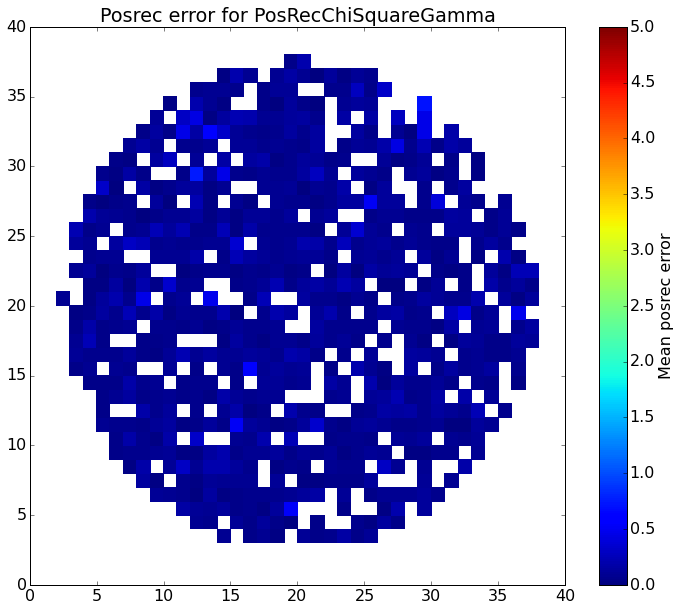

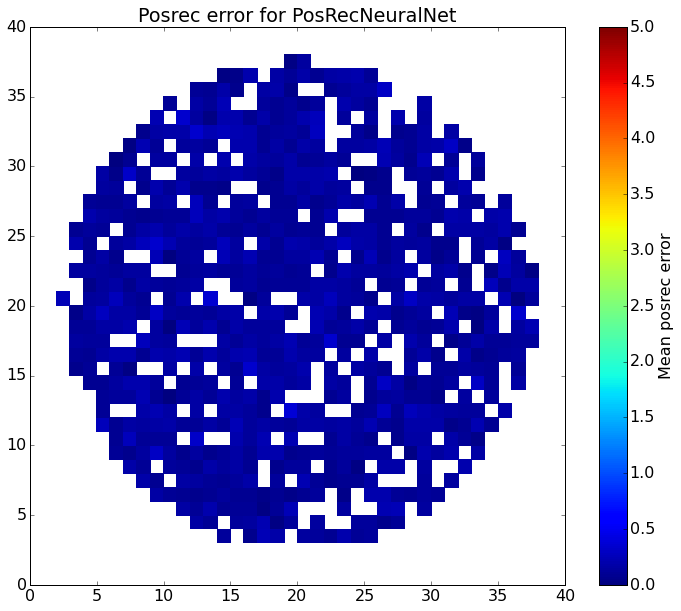

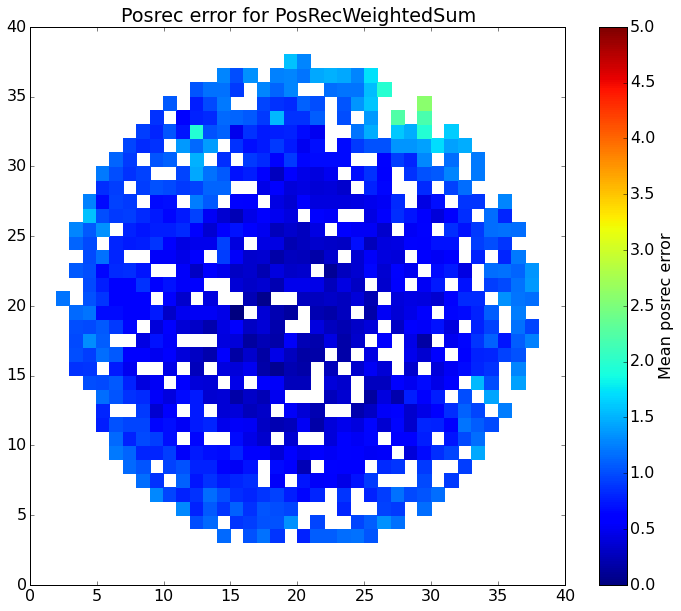

In [98]:
for pp_name in  posrec_plugin.keys():
    twod_stat_plot(ys, xs, differences[pp_name],
                   bins=40, vrange=(0,5),                   
                   cblabel='Mean posrec error')
    plt.title('Posrec error for %s' % pp_name)